## Feature Estimation & PCA Analysis 
- This notebook is used to estimate the features of the neurons and perform PCA analysis. 
- Place Field Features: 
    - Peak Rate 
    - Average Rate
    - Place Field Width
    - Place Field Peak Location
    - Number of Place Fields
    - Percentage of Trials Close to Peak
    - Presence Ratio
- PCA Analysis: 
    - Perform PCA on the features
    - Plot the explained variance
    - Plot the PCA scores
    - Plot the PCA loadings






In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from scipy import stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from convnwb.io import get_files, load_jsons_to_df
from scipy.stats import binom_test
from spiketools.plts.utils import make_grid, get_grid_subplot, save_figure
from spiketools.plts.style import drop_spines
from spiketools.utils.run import create_methods_list

In [3]:
import seaborn as sns
sns.set_context('talk', font_scale=0.9)

In [4]:
import sys
sys.path.append('../code')
from utils import find_place_field,find_place_location
from plts import plot_raster_with_tuning_curve

sys.path.append('../scripts')
from settings import PATHS, METHODS

In [5]:
results_folder = PATHS['RESULTS'] / 'units'
reports_folder = PATHS['REPORTS'] / 'units'


In [6]:
locations_folder = PATHS['BASE'] / 'localization'/'Loc'
locations_files = get_files(locations_folder, select='session_data')
Locations = load_jsons_to_df(locations_files, folder=locations_folder)


In [7]:
# Get the list of files
res_files = get_files(results_folder, select='mat')

In [8]:
# Collect all unit results together into a dataframe
all_results = load_jsons_to_df(res_files, folder=results_folder)

In [9]:
# Get total number of units
n_units = len(all_results)
print('Total number of cells: {}'.format(n_units))
# Collect numbers of significant cells
analyses = create_methods_list(METHODS)
# Statistics settings
alpha_level = 0.05
binom_sidedness = 'greater'   
results = {}
for analysis in analyses:
    all_results[f'is_{analysis}'] = (all_results[f'{analysis}_surr_p_val'] < alpha_level).values

for analysis in analyses:
     results[analysis] = sum(all_results['is_' + analysis])


# Compute significance of the counts of detected neurons
all_stats = {}
for analysis in analyses:
    all_stats[analysis] = binom_test(results[analysis], n_units, alpha_level, binom_sidedness)

Total number of cells: 390


/var/folders/tx/9bxcz_2j6m79n4dmyyw6s2zm0000gn/T/ipykernel_23348/3223072776.py:20: DeprecationWarning: 'binom_test' is deprecated in favour of 'binomtest' from version 1.7.0 and will be removed in Scipy 1.12.0.
  all_stats[analysis] = binom_test(results[analysis], n_units, alpha_level, binom_sidedness)


In [10]:
# Check the number & percent of significant cells per analysis
print('total cells: {}\n'.format( n_units))
for analysis in analyses:
    print('# {} cells:     \t\t{:3d}  ({:5.2f}%) \t\t {:.4f}'.format(\
        analysis, results[analysis], results[analysis] / n_units * 100, all_stats[analysis]))

total cells: 390

# place_anova cells:     		 85  (21.79%) 		 0.0000
# place_info cells:     		 84  (21.54%) 		 0.0000
# place_fr_anova cells:     		 54  (13.85%) 		 0.0000
# place_fr_info cells:     		 63  (16.15%) 		 0.0000


In [11]:
spike_names = all_results['spike_name']
labels = all_results['label']

In [12]:
all_results['channel'] = spike_names.str.extract(r'(?:NSX|CSC)(\d+)')[0].str.lstrip('0')
all_results['sessions'] = all_results['session_id'].str.extract(r'(\w+)_(\d+)_train_events.mat')[0] + '_' + all_results['session_id'].str.extract(r'(\w+)_(\d+)_train_events.mat')[1]


## Exclusion Criteria 

In [13]:
# print(all_results.columns)
# all_results['firing_rate'] = all_results['place_bins'].apply(lambda x: np.mean(x))


# all_results = all_results[all_results['firing_rate'].astype(float) < 20]
# all_results = all_results[all_results['firing_rate'].astype(float) > .1]

## Get Features 

In [14]:
## Compute Features
# Initialize new columns with appropriate data types
all_results['peak_rate'] = np.nan
all_results['average_rate'] = np.nan
all_results['SNR'] = np.nan
all_results['place_field_bins'] = pd.Series([None] * len(all_results))
all_results['noise_bins'] = pd.Series([None] * len(all_results))
all_results['labeled_fields'] = pd.Series([None] * len(all_results))
all_results['N_place_fields'] = pd.Series([None] * len(all_results))
all_results['place_field_peak_location'] = pd.Series([None] * len(all_results))
all_results['trial_peak_loc'] = pd.Series([None] * len(all_results))
all_results['trial_peak_rate'] = pd.Series([None] * len(all_results))
all_results['num_trials_close_to_peak'] = pd.Series([None] * len(all_results))
all_results['percentage_num_trials_close_to_peak'] = pd.Series([None] * len(all_results))

# Calculate basic rate features
all_results['peak_rate'] = all_results['place_bins'].apply(np.max)
all_results['average_rate'] = all_results['place_bins'].apply(np.mean)
all_results['SNR'] = all_results['peak_rate'] / all_results['average_rate']

# Calculate place field features for each unit
for i in range(len(all_results)):
    # Forward direction analysis
    (all_results.at[i,'place_field_bins'], 
     all_results.at[i,'noise_bins'],
     all_results.at[i,'labeled_fields'], 
     all_results.at[i,'N_place_fields'],
     all_results.at[i,'peak_rate'],
     all_results.at[i,'place_field_peak_location']) = find_place_field(all_results['place_bins'][i])

    (all_results.at[i,'trial_peak_loc'],
     all_results.at[i,'trial_peak_rate'], 
     all_results.at[i,'num_trials_close_to_peak'],
     all_results.at[i,'percentage_num_trials_close_to_peak']) = find_place_location(all_results['trial_place_bins'][i], 
                                                                                   all_results['place_field_peak_location'][i],tolerance = 6)



In [15]:
all_results['presence_ratio'] = all_results['trial_fr'].apply(lambda x: np.mean([np.any(np.array(trial) > 0) for trial in x]))

In [16]:
print(all_results.columns)
all_results['firing_rate'] = all_results['place_bins'].apply(lambda x: np.mean(x))

# Create a filtered copy
all_results = all_results[all_results['firing_rate'].astype(float) < 20]
all_results = all_results[all_results['firing_rate'].astype(float) > .1]

# Reset index
all_results = all_results.reset_index(drop=True)

Index(['unit_ind', 'session_id', 'label', 'spike_name', 'place_bins',
       'spike_position', 'trial_changes', 'trial_Num', 'trial_place_bins',
       'place_sem', 'trial_fr', 'fr_bins', 'fr_sem', 's_bins', 'place_info',
       'place_fr_info', 'place_anova', 'place_fr_anova',
       'place_anova_surr_p_val', 'place_anova_surr_z_score',
       'place_info_surr_p_val', 'place_info_surr_z_score',
       'place_fr_anova_surr_p_val', 'place_fr_anova_surr_z_score',
       'place_fr_info_surr_p_val', 'place_fr_info_surr_z_score',
       'is_place_anova', 'is_place_info', 'is_place_fr_anova',
       'is_place_fr_info', 'channel', 'sessions', 'peak_rate', 'average_rate',
       'SNR', 'place_field_bins', 'noise_bins', 'labeled_fields',
       'N_place_fields', 'place_field_peak_location', 'trial_peak_loc',
       'trial_peak_rate', 'num_trials_close_to_peak',
       'percentage_num_trials_close_to_peak', 'presence_ratio'],
      dtype='object')


## Feature Estimation 

In [17]:
peak_rate = all_results['peak_rate']
average_rate = all_results['average_rate']
peak_over_average_rate = peak_rate / average_rate
place_field_width = all_results['place_field_bins']
num_place_fields = all_results['N_place_fields']
place_field_centre_consistency= all_results['percentage_num_trials_close_to_peak']
presence_ratio = all_results['presence_ratio']

In [18]:
place_info = all_results['place_info']
place_anova = all_results['place_anova']


## PCA Feature Input

In [19]:
features = pd.DataFrame({
    'peak_rate': peak_rate,
    'average_rate': average_rate,
    'peak_over_average': peak_over_average_rate,
    'place_field_width': place_field_width,
    'num_place_fields': num_place_fields,
    'place_field_centre_consistency': place_field_centre_consistency,
    'presence_ratio': presence_ratio,
})

## PCA

In [20]:
# Drop NaN values and scale the feature data
mask = features.notna().all(axis=1)
data_no_nan = features[mask]
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_no_nan)

# Performing PCA
pca = PCA()
pca_result = pca.fit_transform(scaled_data)

# Create DataFrame with PCA results and metadata
pca_df = pd.DataFrame(pca_result, columns=[f'PC{i+1}' for i in range(pca_result.shape[1])])
pca_df['unit_ind'] = data_no_nan.index.map(all_results['unit_ind'])
pca_df['session_id'] = data_no_nan.index.map(all_results['session_id'])

# Explained variance
explained_variance_ratio = pca.explained_variance_ratio_

# Calculate cumulative explained variance ratio
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

# Get the feature importance for first two components
feature_names = data_no_nan.columns
components = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(pca.components_.shape[0])],
    index=feature_names
)


## PCA Features Contributions

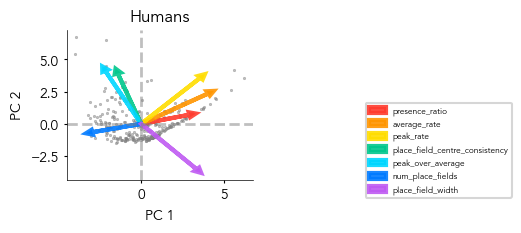

In [39]:
grid = make_grid(3, 3, wspace=1, hspace=0.3, figsize=(12, 7),
                 )

plt.rcParams.update({
    'font.family': 'Avenir',  # Other options similar to Apple SD Gothic Neo: 'Avenir', 'Helvetica Neue', 'SF Pro Text'
    'font.size': 12,
    'axes.titlesize': 12,
    'axes.labelsize': 10,
    'legend.fontsize': 6,
    'xtick.labelsize': 10,  # Smaller tick label size
    'ytick.labelsize': 10,  # Smaller tick label size
    'axes.linewidth': 0.5,  # Reduce the thickness of axis lines

    'xtick.major.width': 0.8,  # Thinner x ticks
    'ytick.major.width': 0.8,  # Thinner y ticks
    'xtick.major.size': 2.0,   # Shorter x ticks
    'ytick.major.size': 2.0

})
ax = get_grid_subplot(grid, 1, 1)
# Use a more distinct color with better contrast
ax.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.5, s=3, 
           color='grey', linewidth=0.5)
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_title('Humans')
drop_spines(['top', 'right'], ax=ax)

# Add reference lines with better styling
ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5, linewidth=2)
ax.axvline(x=0, color='gray', linestyle='--', alpha=0.5, linewidth=2)

arrow_scale = 8
# Create a figure with arrows and labels for each feature
i = 0
arrow_scale = 8

# Define a colormap for the arrows
colors = ['#f57c6e', '#f2b56f', '#fae69e', '#84c3b7', '#88d8db', '#71b7ed', '#b8aeeb']

colors = ['#ff3b2d', '#ff9500', '#ffdd00', '#00c78c', '#00d6ff', '#007aff', '#bf5af2']
# Use brighter colors for better visibility
# Calculate vector angles for sorting
vector_angles = []
for i in range(len(feature_names)):
    angle = np.arctan2(components.iloc[i, 1], components.iloc[i, 0])
    # Convert to degrees and ensure positive angles (0-360)
    angle_deg = np.degrees(angle)
    if angle_deg < 0:
        angle_deg += 360
    vector_angles.append((i, angle_deg))

# Sort features by vector angle
sorted_indices = [idx for idx, _ in sorted(vector_angles, key=lambda x: x[1])]
sorted_feature_names = [feature_names[idx] for idx in sorted_indices]

# Create a list to store legend handles
legend_handles = []

# Plot each feature with a gradient color based on sorted order
for i, idx in enumerate(sorted_indices):
    # Calculate color based on position in the sorted feature list
    color = colors[i]
    
    # Draw arrow
    arrow = ax.arrow(0, 0, components.iloc[idx, 0] * arrow_scale, components.iloc[idx, 1] * arrow_scale, 
             head_width=0.4, head_length=0.4, fc=color, ec=color, linewidth=3, alpha=0.9)
    
    # Add to legend handles
    legend_handles.append((arrow, feature_names[idx]))

# Add legend at the bottom
ax.legend([h for h, l in legend_handles], [l for h, l in legend_handles], 
          loc='lower center', bbox_to_anchor=(2, -0.15), ncol=1, frameon=True)

save_figure('Human_PCA_Feature_Contributions',file_path='/Users/weijiazhang/Plots/PLDM/Human',dpi = 300)


/var/folders/tx/9bxcz_2j6m79n4dmyyw6s2zm0000gn/T/ipykernel_23348/672630516.py:23: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  rect = plt.Rectangle((j * width, 0), width, 1.0,


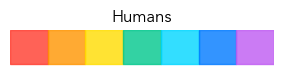

In [44]:
fig_clock, ax_clock = plt.subplots(figsize=(3, 1))

# Calculate angles for each feature vector
angles = []
for i, feature_name in enumerate(feature_names):
    x, y = components.iloc[i, 0], components.iloc[i, 1]
    angle_deg = np.degrees(np.arctan2(y, x)) % 360  # Ensure positive angles (0-360)
    angles.append((feature_name, angle_deg, i))

# Sort features by angle (clockwise from positive x-axis)
angles.sort(key=lambda x: x[1])

# Remove axes
ax_clock.axis('off')

# Plot rectangles in a row
width = 1.0
for j, (feature_name, angle_deg, orig_idx) in enumerate(angles):
    # Use the same color as in the PCA plot (from sorted_indices)
    color_idx = sorted_indices.index(orig_idx)
    
    # Add rectangle with feature name and angle
    rect = plt.Rectangle((j * width, 0), width, 1.0, 
                         color=colors[color_idx % len(colors)], edgecolor='black', linewidth=1, alpha=0.8)
    ax_clock.add_patch(rect)
    
    # Add feature name and angle text

# Set limits and title
ax_clock.set_xlim(0, len(angles) * width)
ax_clock.set_ylim(-0.25, 1.0)
ax_clock.set_title('Humans')
plt.tight_layout()
save_figure('PCA_Humans_Feature_Clockwise_Order', file_path='/Users/weijiazhang/Plots/PLDM/Human', transparent=True, dpi=300)


In [22]:
si_stats = all_results['place_info']
si_sorted = si_stats.sort_values(ascending=True)
si_min_idx  = si_sorted.index[4]
si_max_idx = si_sorted.index[-1]
si_median_idx = si_sorted.index[150]

f_stats = all_results['place_anova']
f_sorted = f_stats.sort_values(ascending=True)
f_min_idx = f_sorted.index[7]
f_max_idx = f_sorted.index[-2]
f_median_idx = f_sorted.index[251]

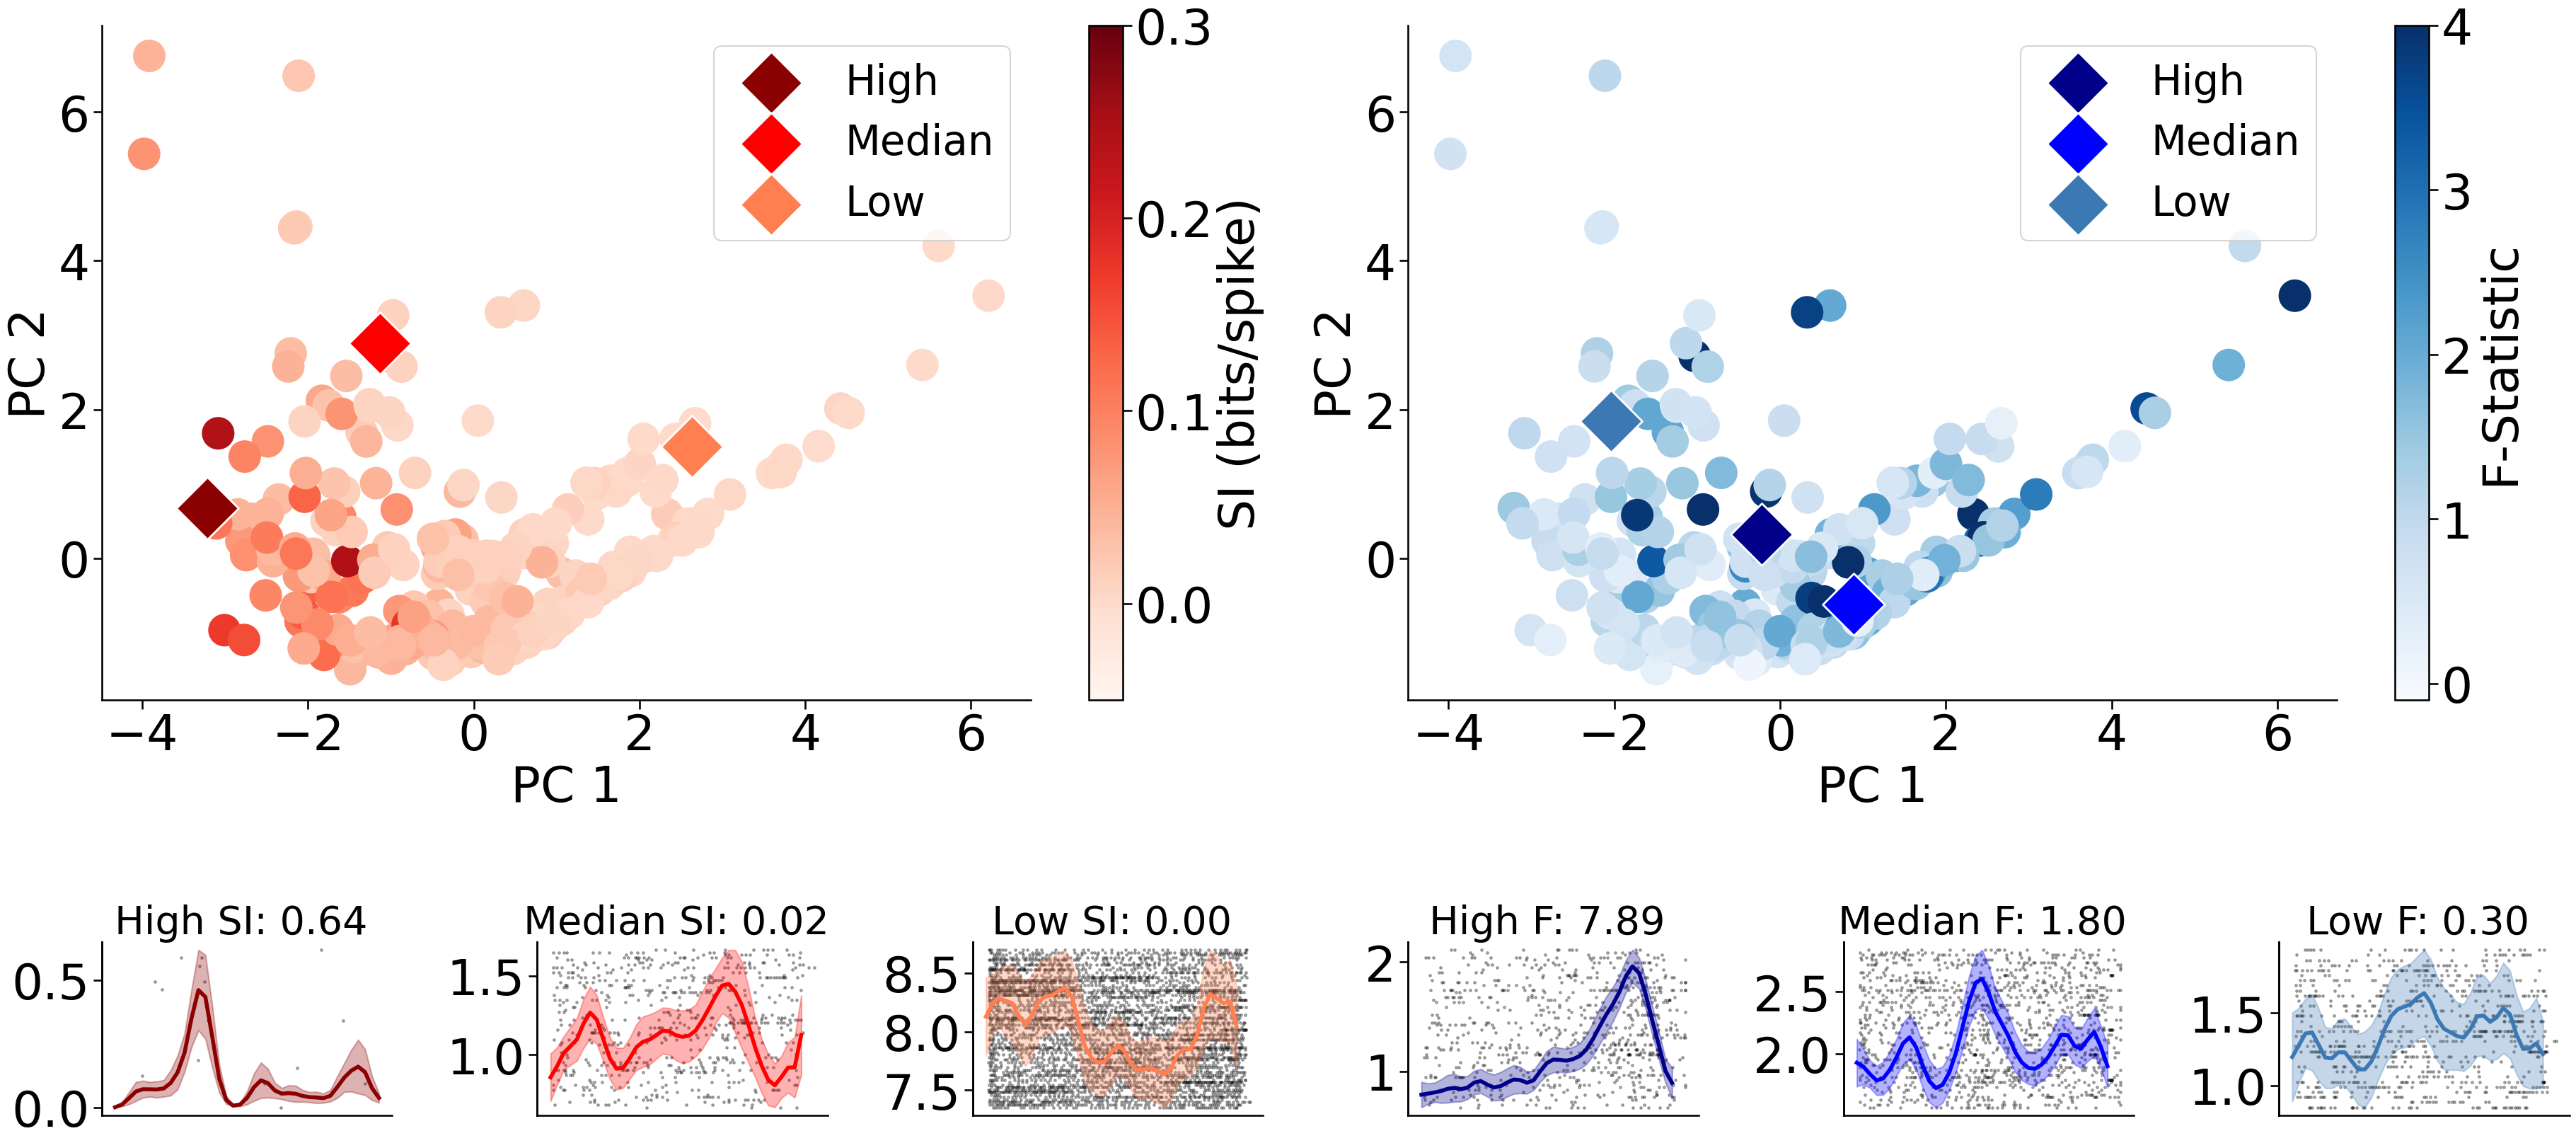

In [23]:
grid = make_grid(5, 6, wspace=.5, hspace=.5, height_ratios=[1,1,1,.5,1], figsize=(45, 20))
plt.rcParams.update({
    'font.size': 50,
    'axes.titlesize': 50,
    'axes.labelsize': 50,
    'xtick.labelsize': 50,
    'ytick.labelsize': 50,
    'legend.fontsize': 50
})

font_size = 40
# Main scatter plots side by side
ax_scatter_si = get_grid_subplot(grid, slice(0,3), slice(0,3))
scatter_si = ax_scatter_si.scatter(
    pca_result[:, 0], pca_result[:, 1],
    c=all_results[mask]['place_info'], s=1000, alpha=1, cmap='Reds',vmin=-.05, vmax=.3
)
plt.colorbar(scatter_si, ax=ax_scatter_si, label='SI (bits/spike)')
ax_scatter_si.set_xlabel('PC 1')
ax_scatter_si.set_ylabel('PC 2')
drop_spines(['top', 'right'], ax=ax_scatter_si)

ax_scatter_anova = get_grid_subplot(grid, slice(0,3), slice(3,6))
scatter_anova = ax_scatter_anova.scatter(
    pca_result[:, 0], pca_result[:, 1],
    c=all_results[mask]['place_anova'], s=1000, alpha=1, cmap='Blues',vmin=-.1, vmax=4
)
plt.colorbar(scatter_anova, ax=ax_scatter_anova, label='F-Statistic')
ax_scatter_anova.set_xlabel('PC 1')
ax_scatter_anova.set_ylabel('PC 2')
drop_spines(['top', 'right'], ax=ax_scatter_anova)

ax_scatter_si.scatter(
    pca_result[si_max_idx, 0],
    pca_result[si_max_idx, 1],
    c='darkred', s=2000, alpha=1, marker='D', edgecolor='white', linewidth=2, label='High',
    zorder=10
)

ax_scatter_si.scatter(
    pca_result[si_median_idx, 0],
    pca_result[si_median_idx, 1],
    c='red', s=2000, alpha=1, marker='D', edgecolor='white', linewidth=2, label='Median',
    zorder=10
)
ax_scatter_si.scatter(
    pca_result[si_min_idx, 0],
    pca_result[si_min_idx, 1],
    c='coral', s=2000, alpha=1, marker='D', edgecolor='white', linewidth=2, label='Low',
    zorder=10
)

ax_scatter_si.legend(loc='upper right', fontsize='small', frameon=True)


ax_scatter_anova.scatter(
    pca_result[f_max_idx, 0],
    pca_result[f_max_idx, 1],
    c='darkblue', s=2000, alpha=1, marker='D', edgecolor='white', linewidth=2, label='High',
    zorder=10
)

ax_scatter_anova.scatter(
    pca_result[f_median_idx, 0],
    pca_result[f_median_idx, 1],
    c='blue', s=2000, alpha=1, marker='D', edgecolor='white', linewidth=2, label='Median',
    zorder=10
)
ax_scatter_anova.scatter(
    pca_result[f_min_idx, 0],
    pca_result[f_min_idx, 1],
    c='#3c79b4', s=2000, alpha=1, marker='D', edgecolor='white', linewidth=2, label='Low',
    zorder=10
)

ax_scatter_anova.legend(loc='upper right', fontsize='small', frameon=True)

## Plot Examples 

idx = si_max_idx
ax = get_grid_subplot(grid, 4, 0)
plot_raster_with_tuning_curve(all_results,idx,ax=ax,curve_color='darkred')
ax.set_title(f'High SI: {all_results.at[idx,"place_info"]:.2f} ', fontsize=font_size)

idx = si_median_idx
ax = get_grid_subplot(grid, 4, 1)
plot_raster_with_tuning_curve(all_results,idx,ax=ax,curve_color='red')
ax.set_title(f'Median SI: {all_results.at[idx,"place_info"]:.2f} ', fontsize=font_size)

idx = si_min_idx
ax = get_grid_subplot(grid, 4, 2)
plot_raster_with_tuning_curve(all_results,idx,ax=ax,curve_color='coral')
ax.set_title(f'Low SI: {all_results.at[idx,"place_info"]:.2f} ', fontsize=font_size)    

idx = f_max_idx
ax = get_grid_subplot(grid, 4, 3)
plot_raster_with_tuning_curve(all_results,idx,ax=ax,curve_color='darkblue')
ax.set_title(f'High F: {all_results.at[idx,"place_anova"]:.2f} ', fontsize=font_size)

idx = f_median_idx
ax = get_grid_subplot(grid, 4, 4)
plot_raster_with_tuning_curve(all_results,idx,ax=ax,curve_color='blue')
ax.set_title(f'Median F: {all_results.at[idx,"place_anova"]:.2f} ', fontsize=font_size)

idx = f_min_idx
ax = get_grid_subplot(grid, 4, 5)
plot_raster_with_tuning_curve(all_results,idx,ax=ax,curve_color='#3c79b4' )
ax.set_title(f'Low F: {all_results.at[idx,"place_anova"]:.2f} ', fontsize=font_size)

save_figure('Human_PCA',file_path='/Users/weijiazhang/Plots/PLDM/Human')



## PCA Analysis With Respect to Features 

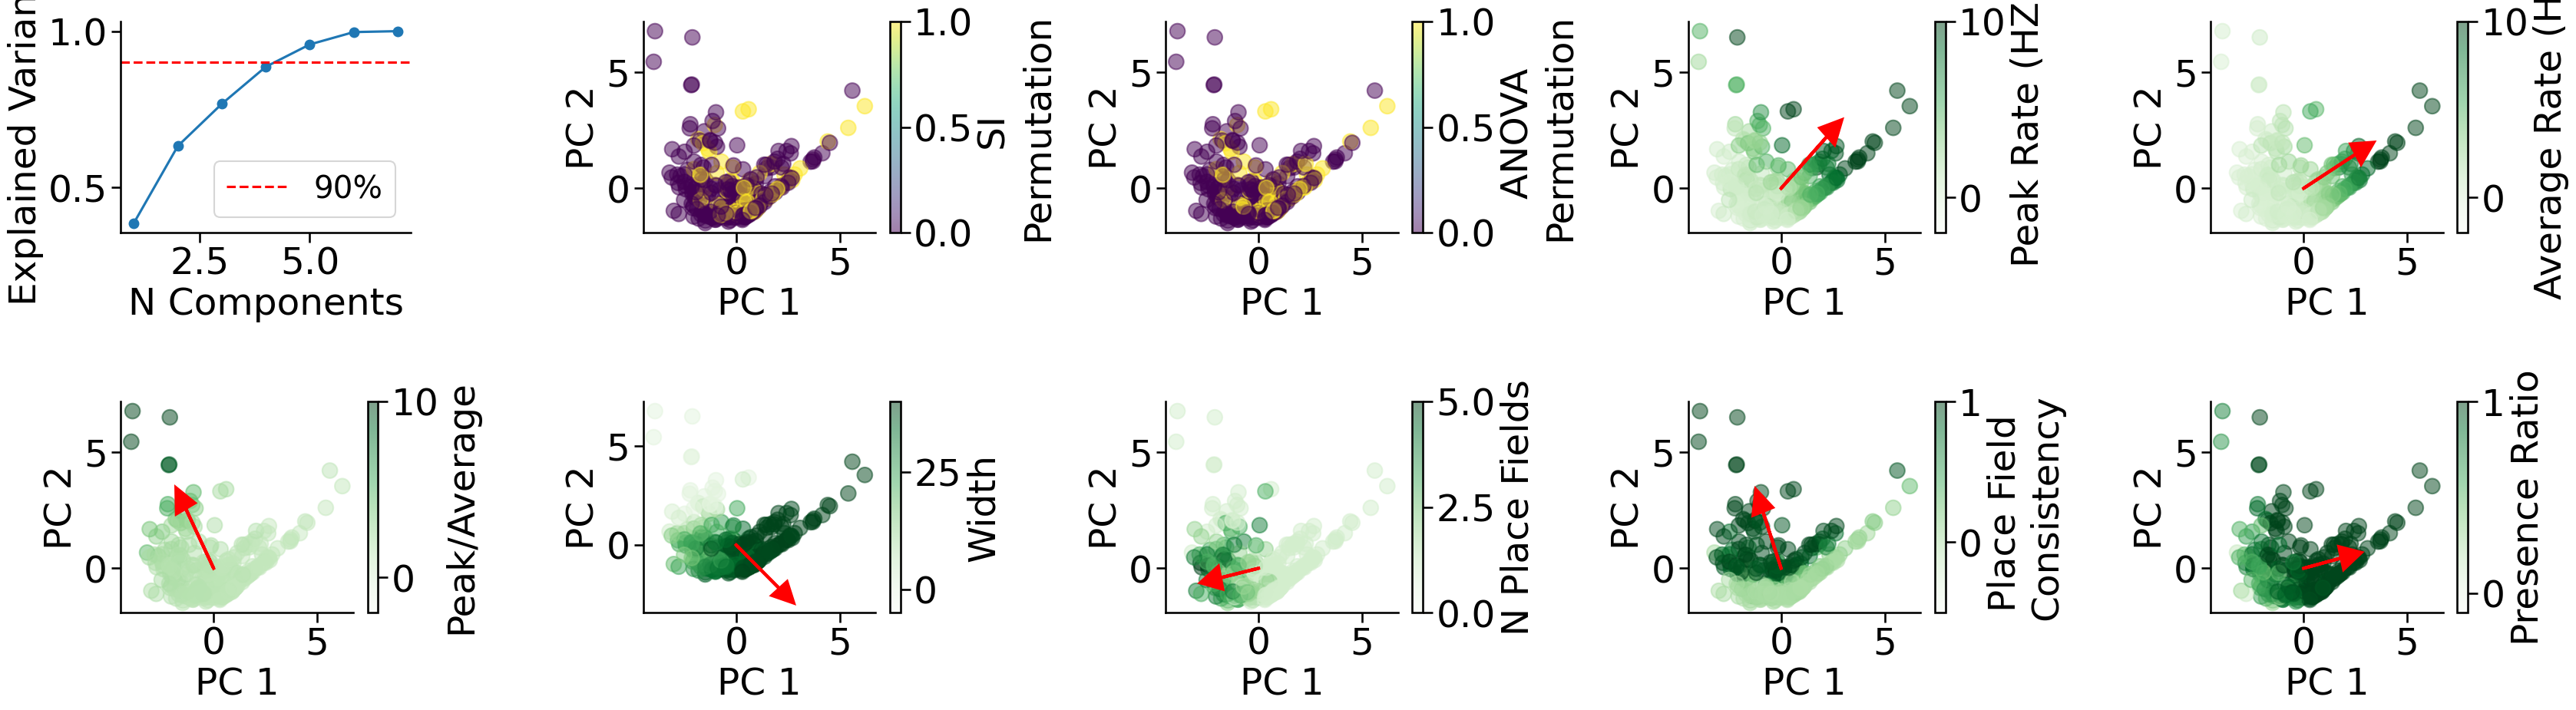

In [24]:
grid = make_grid(2, 5, wspace=.8, hspace=.8, figsize=(40,10))
plt.rcParams.update({
    'font.size': 35,
    'axes.titlesize': 35,
    'axes.labelsize': 35,
    'xtick.labelsize': 35,
    'ytick.labelsize': 35,
    'legend.fontsize': 35
})

ax = get_grid_subplot(grid, 0, 0)
ax.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o')
ax.axhline(y=0.9, color='r', linestyle='--', label='90%')
ax.set_xlabel('N Components')
ax.set_ylabel('Explained Variance')
ax.legend(loc='lower right', fontsize='small', frameon=True)
drop_spines(['top', 'right'], ax=ax)


ax_scatter_si = get_grid_subplot(grid, 0, 1)
scatter_si = ax_scatter_si.scatter(
    pca_result[:, 0], pca_result[:, 1],
    c=all_results[mask]['is_place_info'], s=200, alpha=.5, cmap='viridis'
)
plt.colorbar(scatter_si, ax=ax_scatter_si, label='SI \nPermutation')
ax_scatter_si.set_xlabel('PC 1')
ax_scatter_si.set_ylabel('PC 2')
drop_spines(['top', 'right'], ax=ax_scatter_si)

ax_scatter_anova = get_grid_subplot(grid, 0, 2)
scatter_anova = ax_scatter_anova.scatter(
    pca_result[:, 0], pca_result[:, 1],
    c=all_results[mask]['is_place_anova'], s=200, alpha=.5, cmap='viridis'
)
plt.colorbar(scatter_anova, ax=ax_scatter_anova, label='ANOVA \nPermutation')
ax_scatter_anova.set_xlabel('PC 1')
ax_scatter_anova.set_ylabel('PC 2')
drop_spines(['top', 'right'], ax=ax_scatter_anova)

ax=get_grid_subplot(grid, 0, 3)
scatter_peak_rate = ax.scatter(pca_result[:, 0], pca_result[:, 1],
    c=features['peak_rate'], s=200, alpha=.5, cmap='Greens',vmin=-2, vmax=10
)
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
drop_spines(['top', 'right'], ax=ax)
plt.colorbar(scatter_peak_rate, ax=ax, label='Peak Rate (HZ)')
# Get the index for the peak_rate feature
i= feature_names.get_loc('peak_rate')
ax.arrow(0, 0, 
        components.iloc[i, 0] * 5, 
        components.iloc[i, 1] * 5, 
        head_width=1.0, head_length=1.0, fc='red', ec='red', linewidth=3)

ax=get_grid_subplot(grid, 0, 4)
scatter_peak_rate = ax.scatter(pca_result[:, 0], pca_result[:, 1],
    c=features['average_rate'], s=200, alpha=.5, cmap='Greens',vmin=-2, vmax=10
)
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
drop_spines(['top', 'right'], ax=ax)
plt.colorbar(scatter_peak_rate, ax=ax, label='Average Rate (HZ)')
i= feature_names.get_loc('average_rate')
ax.arrow(0, 0, 
        components.iloc[i, 0] * 5, 
        components.iloc[i, 1] * 5, 
        head_width=1.0, head_length=1.0, fc='red', ec='red', linewidth=3)

ax=get_grid_subplot(grid, 1,0)
scatter_peak_rate = ax.scatter(pca_result[:, 0], pca_result[:, 1],
    c=features['peak_over_average'], s=200, alpha=.5, cmap='Greens',vmin=-2, vmax=10
)
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
drop_spines(['top', 'right'], ax=ax)
plt.colorbar(scatter_peak_rate, ax=ax, label='Peak/Average')
i = feature_names.get_loc('peak_over_average')
ax.arrow(0, 0, 
        components.iloc[i, 0] * 5, 
        components.iloc[i, 1] * 5, 
        head_width=1.0, head_length=1.0, fc='red', ec='red', linewidth=3)


ax=get_grid_subplot(grid, 1, 1)
scatter_peak_rate = ax.scatter(pca_result[:, 0], pca_result[:, 1],
    c=features['place_field_width'], s=200, alpha=.5, cmap='Greens',vmin=-5, vmax=40
)
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
drop_spines(['top', 'right'], ax=ax)
plt.colorbar(scatter_peak_rate, ax=ax, label='Width')
i = feature_names.get_loc('place_field_width')
ax.arrow(0, 0, 
        components.iloc[i, 0] * 5, 
        components.iloc[i, 1] * 5, 
        head_width=1.0, head_length=1.0, fc='red', ec='red', linewidth=3)


ax=get_grid_subplot(grid, 1, 2)
scatter_peak_rate = ax.scatter(pca_result[:, 0], pca_result[:, 1],
    c=features['num_place_fields'], s=200, alpha=.5, cmap='Greens',vmin=0, vmax=5
)
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
drop_spines(['top', 'right'], ax=ax)
plt.colorbar(scatter_peak_rate, ax=ax, label='N Place Fields')
i = feature_names.get_loc('num_place_fields')
ax.arrow(0, 0, 
        components.iloc[i, 0] * 5, 
        components.iloc[i, 1] * 5, 
        head_width=1.0, head_length=1.0, fc='red', ec='red', linewidth=3)

ax=get_grid_subplot(grid, 1, 3)
scatter_peak_rate = ax.scatter(pca_result[:, 0], pca_result[:, 1],
    c=features['place_field_centre_consistency'], s=200, alpha=.5, cmap='Greens',vmin=-.5, vmax=1
)
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
drop_spines(['top', 'right'], ax=ax)
plt.colorbar(scatter_peak_rate, ax=ax, label='Place Field \nConsistency')
i = feature_names.get_loc('place_field_centre_consistency')
ax.arrow(0, 0, 
        components.iloc[i, 0] * 5, 
        components.iloc[i, 1] * 5, 
        head_width=1.0, head_length=1.0, fc='red', ec='red', linewidth=3)

ax=get_grid_subplot(grid, 1, 4)
scatter_peak_rate = ax.scatter(pca_result[:, 0], pca_result[:, 1],
    c=features['presence_ratio'], s=200, alpha=.5, cmap='Greens',vmin=-.1, vmax=1
)
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
drop_spines(['top', 'right'], ax=ax)

plt.colorbar(scatter_peak_rate, ax=ax, label='Presence Ratio')
i = feature_names.get_loc('presence_ratio')
ax.arrow(0, 0, 
        components.iloc[i, 0] * 5, 
        components.iloc[i, 1] * 5, 
        head_width=1.0, head_length=1.0, fc='red', ec='red', linewidth=3)
save_figure('Human_PCA_Features',file_path='/Users/weijiazhang/Plots/PLDM/Human')

